In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas_datareader as pdr
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.metrics import accuracy_score

# 맥 폰트 깨짐 이슈 해결
from matplotlib import rc
%matplotlib inline
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

<>:14: SyntaxWarning: invalid escape sequence '\.'
<>:14: SyntaxWarning: invalid escape sequence '\.'
/var/folders/bs/rn4q13z924s9_wzlq41h6grc0000gn/T/ipykernel_1287/497820950.py:14: SyntaxWarning: invalid escape sequence '\.'
  dataset['Title'] = dataset['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
/var/folders/bs/rn4q13z924s9_wzlq41h6grc0000gn/T/ipykernel_1287/497820950.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset['Age'].fillna(dataset['Age'].median(), inplace=True)
/var/folders/bs/rn4q13z924s9_wzlq41h

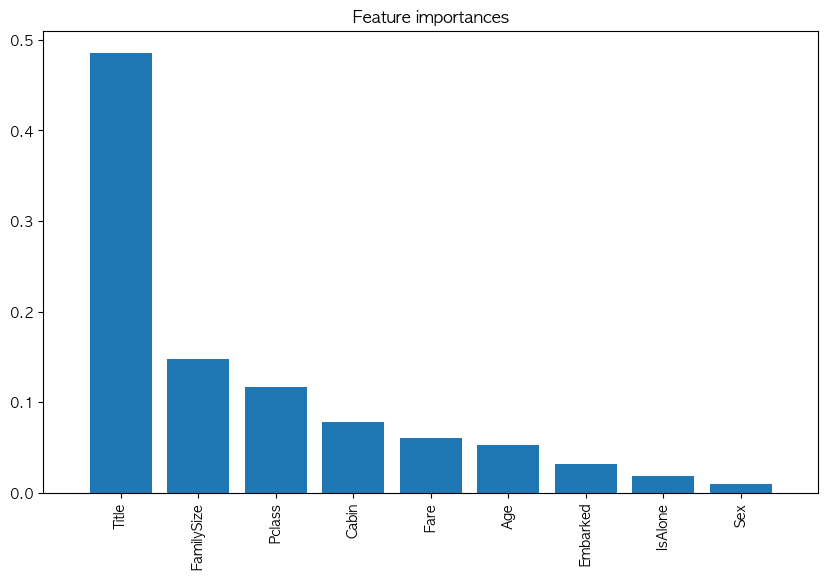

In [11]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score

# 데이터 로드
train = pd.read_csv('titanic/train.csv')
test = pd.read_csv('titanic/test.csv')

# Title 추출 및 맵핑
for dataset in [train, test]:
    dataset['Title'] = dataset['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in [train, test]:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

# Name, Ticket 컬럼 삭제
train = train.drop(['Name', 'Ticket'], axis=1)
test = test.drop(['Name', 'Ticket'], axis=1)

# Sex 맵핑
for dataset in [train, test]:
    dataset['Sex'] = dataset['Sex'].map({"male": 0, "female": 1})

# Age 결측치 처리 및 범주화
for dataset in [train, test]:
    dataset['Age'].fillna(dataset['Age'].median(), inplace=True)
    dataset.loc[dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[dataset['Age'] > 64, 'Age'] = 4

# Embarked 결측치 처리 및 맵핑
for dataset in [train, test]:
    dataset['Embarked'].fillna('S', inplace=True)
    dataset['Embarked'] = dataset['Embarked'].map({"S": 0, "C": 1, "Q": 2})

# Fare 결측치 처리 및 범주화
test['Fare'].fillna(test['Fare'].median(), inplace=True)
for dataset in [train, test]:
    dataset.loc[dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
    dataset.loc[dataset['Fare'] > 31, 'Fare'] = 3

# Cabin 결측치 처리 및 맵핑
for dataset in [train, test]:
    dataset['Cabin'] = dataset['Cabin'].str[:1]
    dataset['Cabin'] = dataset['Cabin'].map({"A": 0, "B": 0.5, "C": 1, "D": 1.5, "E": 2, "F": 2.5, "G": 3, "T": 3.5})
    dataset['Cabin'].fillna(0, inplace=True)

# FamilySize 생성 및 IsAlone 피처 추가
for dataset in [train, test]:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

# 불필요한 컬럼 삭제
train = train.drop(['PassengerId', 'SibSp', 'Parch'], axis=1)
test = test.drop(['SibSp', 'Parch'], axis=1)

# Standardization
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train.drop('Survived', axis=1))
test_scaled = scaler.transform(test.drop('PassengerId', axis=1))

# 특성과 타겟 분리
X_train = train_scaled
y_train = train['Survived']
X_test = test_scaled

# 모델 학습
model = DecisionTreeClassifier(random_state=20240614)
model.fit(X_train, y_train)

# 테스트 데이터 예측
predictions = model.predict(X_test)

# 제출 파일 생성
submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": predictions
    })

submission.to_csv('20240614submission_tree.csv', index=False)

# 모델 피처 중요도 시각화
importances = model.feature_importances_
features = train.drop('Survived', axis=1).columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), features[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()
